# Protein prediction project #

Author: Maria Alejandra Ulloa
Course: Bioinformatics

This notebook trains a Neural Network for seconday protein prediction taking as input a PSSM.

In [1]:
import numpy as np
import scipy.stats as stats
import keras
from keras import layers
from keras.layers import Dense, Flatten, Activation, LeakyReLU, BatchNormalization
from keras import models
from keras import optimizers
import tensorflow as tf
import keras_tuner as kt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Parsing the pssm file and dssp functions.

def parse_pssm(pssm_filename):
	'''
	Parse the pssm file and return the profile matrix
	'''
	profile = []
	with open(pssm_filename) as pssm:
		pssm_lines = pssm.readlines()
		for line in pssm_lines[3:-6]:
			profile_line = []
			for n in line.rstrip().split()[22:-2]:
				profile_line.append(float(n)/100)
			profile.append(profile_line)
	return profile

def parse_dssp(dssp_filename):
	''' Parse the dssp file and return the secondary structure sequence'''
	ss = ''
	with open(dssp_filename) as dssp:
		dssp.readline()
		ss = dssp.readline().rstrip()
	return ss

def seq_to_profile(seq):
	''' Convert the sequence to a profile matrix
	'''
	profile = []
	aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
	for res in seq:
		profile_line = []
		for aa in aa_list:
			if res == aa:
				profile_line.append(1)
			else:
				profile_line.append(0)
		profile.append(profile_line)
	return profile

def profiles(profile, x_train, y_train, ss_map, window_size, ss):
	'''
	 Extract the features and labels from the profile matrix
	 '''
	for i in range(0, len(profile)):
		half_window_size = int((window_size-1)/2)
		part1 = np.zeros(20*max(0, half_window_size-i))
		part2 = np.ndarray.flatten(profile[max(0,i-half_window_size):min(i+half_window_size+1,len(profile))])
		part3 = np.zeros(20*max(0, half_window_size-(len(profile)-i-1)))
		vec = np.concatenate((part1, part2, part3))
		x_train.append(vec.tolist())
		y_train.append(ss_map[ss[i]])
	return x_train, y_train


# Extract features from pssm files. The features are the pssm values for each amino acid in a window of size 15.
# the window size is 15, so the features are 15*20=300. The labels are the secondary structure of the central amino acid in the window.
# The labels are H, E, C. The labels are converted to numbers 0, 1, and 2, respectively. The labels are stored in y_train.
# The features are stored in x_train. 	

def extract_features(file_path, pssm_file, dssp_file, window_size):
	''' 
	Extract features from the pssm files and return the features and labels
	'''

	with open(file_path) as id_list:
			x_train, y_train = [], []
			ss_map = {'H': 0, 'E': 1, 'C': 2, '-': 2}
			for line in id_list:
				line = line.rstrip()
				if ":" in line:
					line = line.replace(":", "_")
				profile = np.array(parse_pssm(f"{pssm_file}\\{line}.pssm"))
				if np.sum(profile) != 0:
					ss = parse_dssp(f"{dssp_file}\\{line}.dssp")
					x_train, y_train = profiles(profile, x_train, 
												y_train, ss_map, 
												window_size, ss)

			x_train, y_train = np.array(x_train), np.array(y_train)
			y_train = keras.utils.to_categorical(y_train, 3) # Create one-hot encoding for the labels
			
	return x_train, y_train


### Create training data-set and test data-set

- **Training set**

In [5]:
window_size=17
file_path = r"data\training\list.txt"
pssm_files = "data\\training\\pssm"
dssp_files = "data\\training\\dssp"

x_train, y_train = extract_features(file_path, pssm_files, dssp_files, window_size)
print(x_train.shape)
print(y_train.shape)

(198144, 340)
(198144, 3)


- **Test set**

In [6]:
window_size=17
file_path = r"data\blindTest\list.txt"
pssm_files = "data\\blindTest\\pssm"
dssp_files = "data\\blindTest\\dssp"

x_test, y_test = extract_features(file_path, pssm_files, dssp_files, window_size)
print(x_test.shape)
print(y_test.shape)

(62136, 340)
(62136, 3)


### **Model building & hyperparameter tuning**

### **Model hyperparameter tuning**

Using Keras hyperparameter tuning. We are researching the best space for the following parameters:
- Number of dense layers
- Number of units for each layer
- Activation function: relu or tanh
- Regularization techniques
- Need of a dropout layer

In [3]:
# Generate model
def model_builder(hp):
    '''
    Build a model with hyperparameters
    '''
    model = keras.Sequential([keras.Input(shape=((340)))])
    model.add(layers.Flatten())
    #Tune number of layers
    for i in range(hp.Int("num_layers", min_value=1, max_value=4, step=1)):
        model.add(
            #Tune number of units and activation function for each layer
            layers.Dense(units=hp.Int(f"units_{i}", min_value=17, max_value=204, step=17), 
                        activation=hp.Choice("activation", ["relu", "tanh"]),
                        )
        )
    # Add dropout layer
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(3, activation='softmax')) # Output layer
    model.compile(optimizer='adam', loss="categorical_crossentropy",metrics=["accuracy"])
   
    return model  

model_builder(kt.HyperParameters())  

In [ ]:
# Instantiate the tuner: Hyperband
tuner_2 = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='Hyperparameter_tuning',
                     project_name='protein-prediction-hb')
tuner_2.search_space_summary()

# Perform hyperparameter tuning
tuner_2.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
model_random = tuner_2.get_best_models(num_models=1)
best_model_ra = model_random[0]
best_model_ra.summary()

In [ ]:
# Instantiate the tuner: BayesianOptimization
tuner_3 = kt.BayesianOptimization(model_builder,
                     objective='val_accuracy',
                     max_trials=10,
                     directory='Hyperparameter_tuning',
                     project_name='protein-prediction')
tuner_3.search_space_summary()

tuner_3.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
models = tuner_3.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

### **Model cross-validation**

Using as a base model the one sujested by the hyperparameter tuning utils by keras we now take a step foward the optimization of the model using the cross-validation sets. We will focus on three[subjected to change] aspects:
- Window size for the sliding window technique
- Regularization techniques
- Dropout


In [5]:
# Cross-validation data
# Feature extraction
def cv_features(window_size):
    ''' 
    Extract features from the cross-validation data 
    and return the features and labels
    '''
    cv_train, cv_train_ss, cv_test, cv_test_ss = [], [], [], []
    id_list = [["train1", "test1"], 
            ["train2", "test2"], 
            ["train3", "test3"], 
            ["train4", "test4"],
            ["train5", "test5"]]

    for train, test in id_list:
        train_path=f"data\\training\\cv\\{train}.txt"
        test_path =f"data\\training\\cv\\{test}.txt"
        pssm_files = "data\\training\\pssm"
        dssp_files = "data\\training\\dssp"

        x_train, y_train = extract_features(train_path, pssm_files, dssp_files, window_size)
        x_test, y_test = extract_features(test_path, pssm_files, dssp_files, window_size)
        print(f"Features and labels extracted: {train} and {test}")
        cv_train.append(x_train)
        cv_train_ss.append(y_train)
        cv_test.append(x_test)
        cv_test_ss.append(y_test)

    return cv_train, cv_train_ss, cv_test, cv_test_ss


In [13]:
# Define the model architecture following the best hyperparameters

def cv_model(train_set, train_ss, test_set, ss_test, activation='leaky', regularizer=None, dropout=False, batch_norm=False):
    ''' 
    Define the model architecture, training, and evaluation 
    '''
    
    # Define the model architecture
    model = keras.Sequential([
        Flatten(input_shape=(train_set.shape[1],)),
    ])
    
    if activation == 'leaky':
        model.add(layers.Dense(136))
        model.add(LeakyReLU(alpha=0.3))
    elif activation == 'relu':
        model.add(layers.Dense(136, activation='relu'))
    elif activation == 'sigmoid':
        model.add(layers.Dense(136, activation='sigmoid'))
    else:
        raise ValueError("Invalid activation function specified.")
    
    model.add(layers.Dense(153, activation='relu'))

    if dropout: 
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(85, activation='relu'))
    if dropout: 
        model.add(layers.Dropout(rate=0.25))
    # Add batch normalization
    if batch_norm:
        model.add(BatchNormalization())

    model.add(layers.Dense(3, activation='softmax'))

    # Add activity regularization if specified
    if regularizer:
        model.add(layers.ActivityRegularization(l1=regularizer, l2=regularizer))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
    # Train the model
    history = model.fit(train_set,
                        train_ss,
                        epochs=4,
                        batch_size=128,
                        validation_split=0.2,
                        verbose=0
                        )
        
    # Evaluate the model
    loss, accuracy = model.evaluate(test_set, ss_test)
    # Predict with the model
    ss_pred = model.predict(test_set)
    
    return accuracy, loss, history, ss_pred

In [7]:
# Cross-validation
def cross_validation(window_size, activation, regularizer=None, dropout=False, batch_norm=False):
    ''' Perform cross-validation'''
    
    #Take the features and labels from the cross-validation data
    cv_train, cv_train_ss, cv_test, cv_test_ss = cv_features(window_size)
    accuracy_cv, loss_cv, history_cv, ss_pred_cv = [], [], [], []
    # Train and evaluate the model for each fold
    for i in range(len(cv_train)):
        accuracy, loss, history, ss_pred = cv_model(cv_train[i], 
                                                    cv_train_ss[i],
                                                    cv_test[i],
                                                    cv_test_ss[i],
                                                    activation=activation,
                                                    regularizer=regularizer,
                                                    dropout=dropout,
                                                    batch_norm=batch_norm)
        accuracy_cv.append(accuracy)
        loss_cv.append(loss)
        history_cv.append(history)
        ss_pred_cv.append(ss_pred)
        
    return accuracy_cv, loss_cv, history_cv, ss_pred_cv, cv_test_ss


In [8]:
def training_accuracy(history_cv, epochs):
    '''
    Print the training accuracy for each training set
    '''
    accuracies = []
    for hist in history_cv:
        accuracies.append(hist.history['accuracy'][epochs - 1])
    for i in range(len(accuracies)):
        print(f'Accuracy training set {i + 1}: {accuracies[i]}')

def hyperparameter_means(history_cv, accuracy_cv, hp_num, epochs):
    ''' 
    Calculates the mean and standard deviation
    of the accuracy for the training and validation sets
    '''
    # Mean accuracy training sets
    accuracies = []
    for hist_lis in history_cv:
        for hist in hist_lis:
            accuracies.append(hist.history['accuracy'][epochs])

    # Mean accuracy training sets
    train_mean = np.array(accuracies).reshape(-1, hp_num)
    mean_tr = np.mean(train_mean, axis=0)
    sd_tr = np.std(train_mean, axis=0)

    # Mean accuracy validation sets
    val_mean = np.array(accuracy_cv).reshape(-1, hp_num)
    mean_val = np.mean(val_mean, axis=0)
    sd_val = np.std(val_mean, axis=0)

    return mean_tr, sd_tr, mean_val, sd_val

def print_accuracy_statistics(accuracy_cv):
    ''' 
    Print the mean and standard deviation of the accuracy
    for the validation sets
    '''
    for i in range(len(accuracy_cv)):
        print(f"Validation accuracy for training set {i+1}: {accuracy_cv[i]}")
    accuracy_val_mean = np.mean(accuracy_cv)
    print(f"Mean accuracy for validation with test data: {accuracy_val_mean}")
    accuracy_val_sd = np.std(accuracy_cv)
    print(f"Standard deviation: {accuracy_val_sd}")

In [9]:
### Cross-validation plot

def plt_hp_search(hp, mean_tr, mean_val, x_label, title, save_name):
    ''' 
    Plot the accuracy for the different hyperparameters values explored
    '''
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  

    # Plot accuracy training sets
    axs[0].set_title(f'Training: {title}')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel(x_label)
    axs[0].plot(hp, mean_tr, marker='o')
    axs[0].grid(True)

    # Plot accuracy validation 
    axs[1].set_title(f'Validation: {title}')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel(x_label)
    axs[1].plot(hp, mean_val, marker='o')
    axs[1].grid(True)

    # Set x-axis ticks to only show odd numbers
    axs[0].set_xticks(hp[::2])
    axs[1].set_xticks(hp[::2])

    plt.suptitle(title)
    plt.savefig(save_name)
    # plt.show()  # Uncomment this line if you want to display the plot
    plt.close(fig)  # Close the figure to free up memory

# Plot accuracy and loss across cross-validation sets in the training

def cv_plot_accuracies(history_cv, tittle) :
    ''' 
    Plot for the accuracy across epochs for the training sets
    '''
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  

    # Plot accuracy
    axs[0].set_title('Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    for i in range(len(history_cv)):
        axs[0].plot(history_cv[i].history['accuracy'], label=f'Train {i+1}')
    axs[0].legend(loc='upper left')
    axs[0].grid(True)

    # Plot loss
    axs[1].set_title('Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    for i in range(len(history_cv)):
        axs[1].plot(history_cv[i].history['loss'], label=f'Train {i+1}')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)

    plt.savefig(tittle)
    plt.show()
    plt.close(fig)  # Close the figure to free up memory

In [352]:
# Check best window size
window_size = range(3, 20, 2)
accuracy_cv_ws, loss_cv_ws, history_cv_ws, ss_pred_cv_ws, cv_test_ss_ws   = [], [], [], [], []

# Loop through window sizes
for ws in window_size:
    # Cross-validation
    accuracy_cv, loss_cv, history_cv, ss_pred_cv, cv_test_ss = cross_validation(ws, activation= 'relu')
    accuracy_cv_ws.append(accuracy_cv)
    loss_cv_ws.append(loss_cv)
    history_cv_ws.append(history_cv)
    ss_pred_cv_ws.append(ss_pred_cv)
    cv_test_ss_ws.append(cv_test_ss)

Features and labels extracted: train1 and test1
Features and labels extracted: train2 and test2
Features and labels extracted: train3 and test3
Features and labels extracted: train4 and test4
Features and labels extracted: train5 and test5
1239/1239 [==============================] - 3s 2ms/step
Features and labels extracted: train1 and test1
Features and labels extracted: train2 and test2
Features and labels extracted: train3 and test3
Features and labels extracted: train4 and test4
Features and labels extracted: train5 and test5
1239/1239 [==============================] - 3s 2ms/step
Features and labels extracted: train1 and test1
Features and labels extracted: train2 and test2
Features and labels extracted: train3 and test3
Features and labels extracted: train4 and test4
Features and labels extracted: train5 and test5
1239/1239 [==============================] - 3s 2ms/step
Features and labels extracted: train1 and test1
Features and labels extracted: train2 and test2
Features and 

In [ ]:
# Window size plot and means
mean_tr_ws, sd_tr_ws, mean_val_ws, sd_val_ws = hyperparameter_means(history_cv_ws, accuracy_cv_ws, 9, 9)
plt_hp_search(window_size, 
                mean_tr_ws, 
                mean_val_ws, 
                'Window size', 
                'Window size search', 
                'window_size_search.png')


### Optimization for Bayesian model

Hyperparameters:      
Activation: relu
num_layers: 4
Input_layer: 340
Dense_layer_1: 136
Dense_layer_2: 153
Dense_layer_3: 85
Output_layer: 3  

The idea now is to start using some regularization techniques that deal with possible overfitting caused by the number of layers of our model.
Let's first check how the model is behaving with the cross-validation sets:

In [334]:
# With optimize window size and model, train the model with the cross-validation data
accuracy_cv_ws, loss_cv_ws, history_cv_ws, ss_pred_cv_ws, cv_test_ss_ws = cross_validation(17, activation= 'relu')

Features and labels extracted: train1 and test1
Features and labels extracted: train2 and test2
Features and labels extracted: train3 and test3
Features and labels extracted: train4 and test4
Features and labels extracted: train5 and test5
1239/1239 [==============================] - 4s 3ms/step


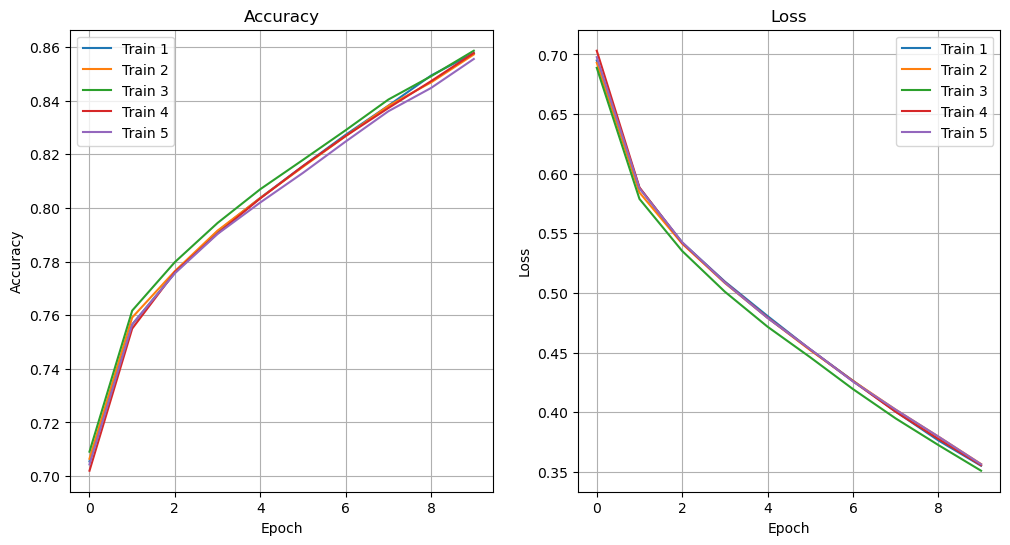

Accuracy training set 1: 0.7912365198135376
Accuracy training set 2: 0.791524350643158
Accuracy training set 3: 0.7943835258483887
Accuracy training set 4: 0.7904335260391235
Accuracy training set 5: 0.7902839183807373
Validation accuracy for training set 1: 0.7348817586898804
Validation accuracy for training set 2: 0.7412354350090027
Validation accuracy for training set 3: 0.7281822562217712
Validation accuracy for training set 4: 0.7330926656723022
Validation accuracy for training set 5: 0.730620801448822
Mean accuracy for validation with test data: 0.7336025834083557
Standard deviation: 0.004436838954024181


In [335]:
# Accuracy and loss plot
cv_plot_accuracies(history_cv_ws, "cv_accuracy_loss_window_size_17.png")
# Accuracy with test data
training_accuracy(history_cv_ws, 4)
# validation accuracy statistics
print_accuracy_statistics(accuracy_cv_ws)


As seen above the model shows signs of overfitting with accuracy training values around 0.8 but accuracy values against the test set of 0.73.


- Number of EPOCHS

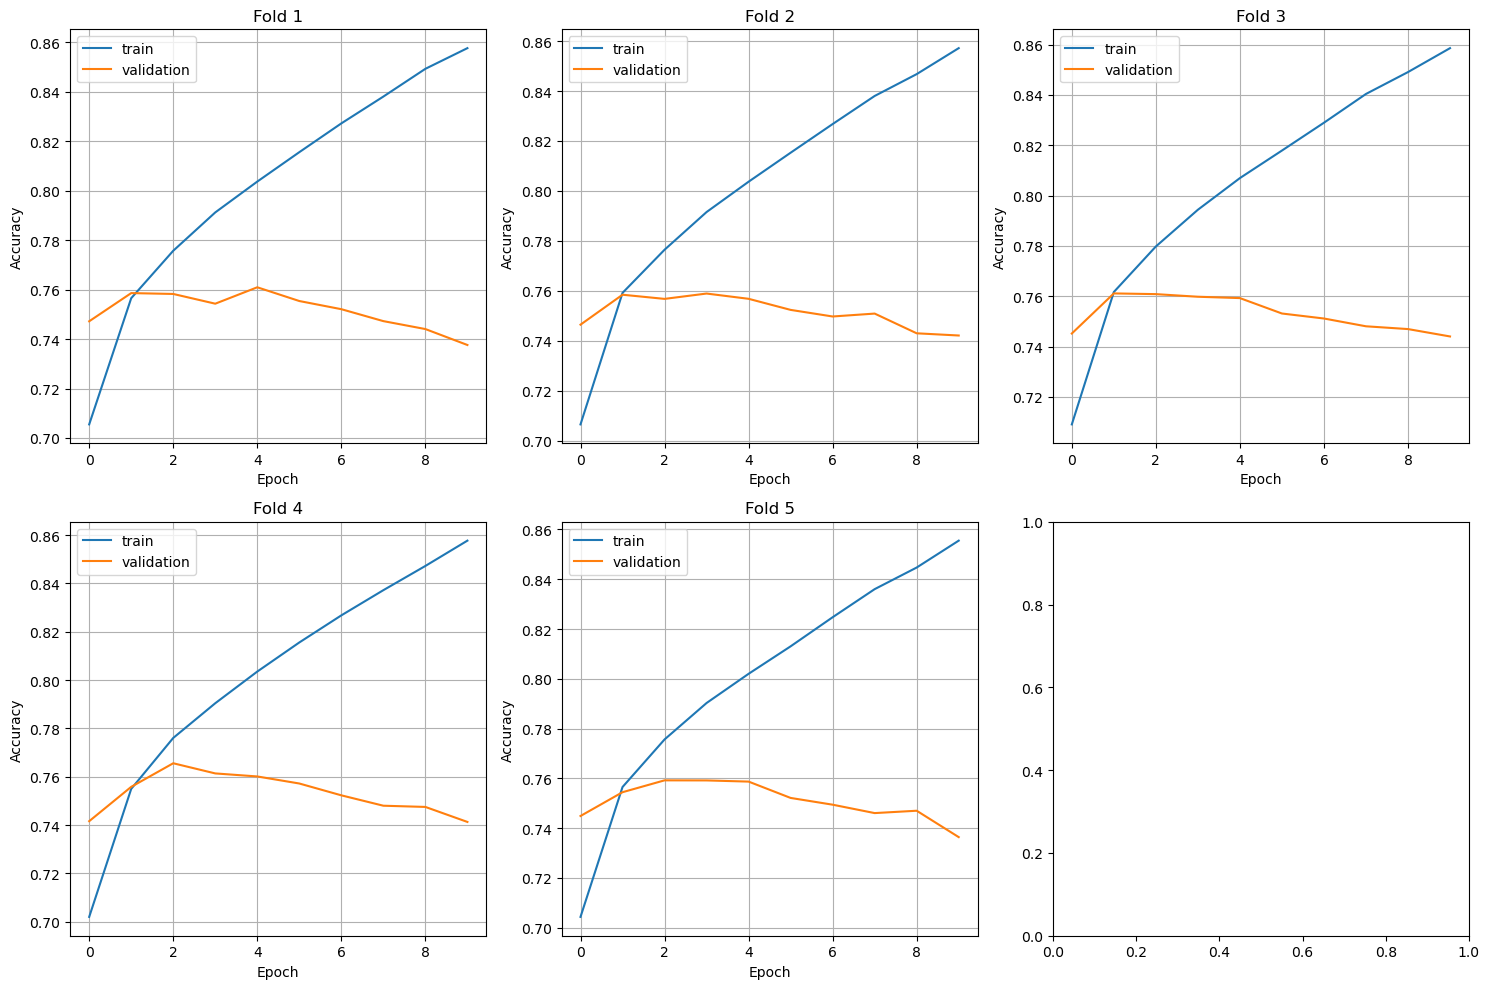

In [336]:
# Plot training accuracy for training and validation sets

def plt_train_val_acc(history, axes, index):
    ax = axes[index // 3, index % 3]
    ax.plot(history.history['accuracy'], label='train')
    ax.plot(history.history['val_accuracy'], label='validation')
    ax.set_title(f'Fold {index+1}')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper left')
    ax.grid(True)

# Assuming you have `history_cv` containing history objects for each fold

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, train_set in enumerate(history_cv_ws):
    plt_train_val_acc(train_set, axes, i+1)

plt.tight_layout()
plt.savefig("train_val_acc_epochs.png")
plt.show()


After looking at these plots a number of 4 epochs seems like a smart training time for our model and training dataset.

Features and labels extracted: train1 and test1
Features and labels extracted: train2 and test2
Features and labels extracted: train3 and test3
Features and labels extracted: train4 and test4
Features and labels extracted: train5 and test5
1239/1239 [==============================] - 3s 2ms/step


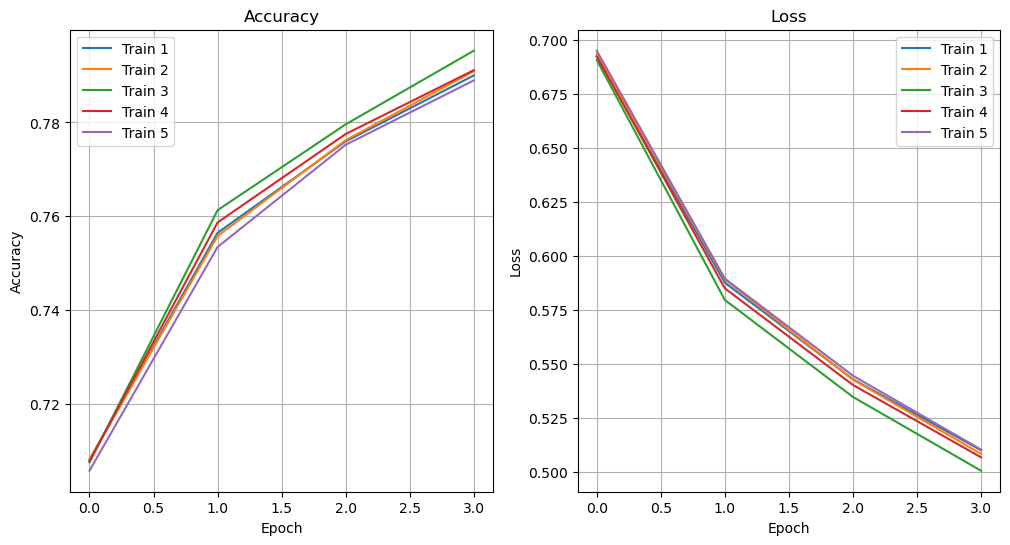

Accuracy training set 1: 0.7900136709213257
Accuracy training set 2: 0.7909184098243713
Accuracy training set 3: 0.7952749133110046
Accuracy training set 4: 0.7911316156387329
Accuracy training set 5: 0.7889510989189148
Validation accuracy for training set 1: 0.7540081739425659
Validation accuracy for training set 2: 0.7576196789741516
Validation accuracy for training set 3: 0.7459993362426758
Validation accuracy for training set 4: 0.7553178071975708
Validation accuracy for training set 5: 0.7542567253112793
Mean accuracy for validation with test data: 0.7534403443336487
Standard deviation: 0.003933172119753693


In [348]:
# With optimize window size and model, train the model with the cross-validation data
accuracy_cv_ep, loss_cv_ep, history_cv_ep, ss_pred_cv_ep, cv_test_ss_ep = cross_validation(17, activation= 'relu')
# Accuracy and loss plot
cv_plot_accuracies(history_cv_ep, "cv_accuracy_loss_window_size_17.png")
# Accuracy with test data
training_accuracy(history_cv_ep, 4)
# validation accuracy statistics
print_accuracy_statistics(accuracy_cv_ep)


Accuracy across cross validation sets for the test sets were higher after implementing a training time of 4 epochs.

- ### Regularization

A regularization layer for the loss function was used after the last layer. Now, we will test the best weight values for L1 and L2.

In [ ]:
# Adding activity regularization

regularizer = [0.01, 0.001, 0.0001, 0.00001]

# Cross-validation
accuracy_cv_re, loss_cv_re, history_cv_re, ss_pred_cv_re, cv_test_ss_re = [], [], [], [], []

for i in regularizer:
    accuracy_cv, loss_cv, history_cv, ss_pred_cv, cv_test_ss = cross_validation(17, activation= 'relu', regularizer=i)
    print(f"Accuracy for regularizer {i}: {accuracy_cv}")
    accuracy_cv_re.append(accuracy_cv)
    loss_cv_re.append(loss_cv)
    history_cv_re.append(history_cv)
    ss_pred_cv_re.append(ss_pred_cv)
    cv_test_ss_re.append(cv_test_ss)


In [346]:
# Regularizer means and standard deviations
mean_tr_re, sd_tr_re, mean_val_re, sd_val_re = hyperparameter_means(history_cv_re, accuracy_cv_re, 4, epochs=3)
print(mean_tr_re)
print(sd_tr_re)
print(mean_val_re)
print(sd_val_re)

# Plot hyperparameter search: regularizer
plt_hp_search(regularizer,
              mean_tr_re,
              mean_val_re,
              "Regularizer",
              "Mean accuracy for each regularization parameter",
              "bayesian_hp_cv_regularizer_2_.png")

[0.77682165 0.7760929  0.77678667 0.77629569]
[0.00180014 0.00185043 0.00191729 0.00205903]
[0.75596929 0.75549263 0.75525606 0.75592859]
[0.0050003  0.00526597 0.00320883 0.00460248]


In [ ]:
### Model evaluation with regularization layer

accuracy_cv, loss_cv, history_cv, ss_pred_cv, cv_test_ss = cross_validation(17, activation= 'relu', regularizer=0.00001)

# Accuracy and loss
cv_plot_accuracies(history_cv, "accuracy_loss_regularized_model.png")
# Accuracy with test data
training_accuracy(history_cv, 4)
# validation accuracy statistics
print_accuracy_statistics(accuracy_cv)


- ### Add leaky ReLu 
For regularization on first layer

Features and labels extracted: train1 and test1
Features and labels extracted: train2 and test2
Features and labels extracted: train3 and test3
Features and labels extracted: train4 and test4
Features and labels extracted: train5 and test5
1239/1239 [==============================] - 2s 2ms/step


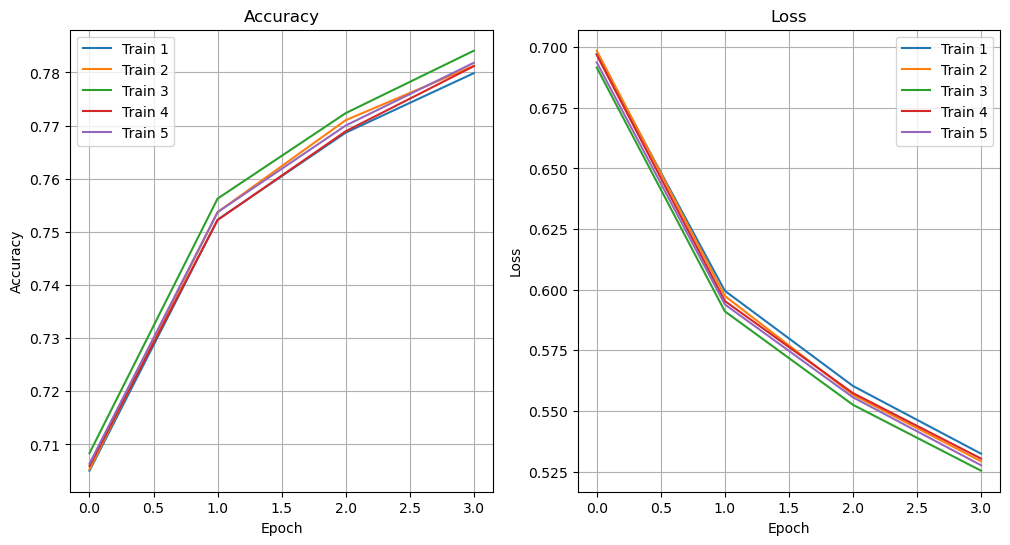

Accuracy training set 1: 0.779873251914978
Accuracy training set 2: 0.7812622785568237
Accuracy training set 3: 0.7840971946716309
Accuracy training set 4: 0.781185507774353
Accuracy training set 5: 0.7818296551704407
Accuracy for training set 1: 0.7614476084709167
Accuracy for training set 2: 0.7575942873954773
Accuracy for training set 3: 0.746100127696991
Accuracy for training set 4: 0.7603455185890198
Accuracy for training set 5: 0.7621521949768066
Mean accuracy for validation with test data: 0.7575279474258423
Standard deviation: 0.0059209050005406775


In [269]:
# Model evaluation with different activation functions

accuracy_cv, loss_cv, history_cv, ss_pred_cv, cv_test_ss = cross_validation(17, activation= 'leaky', regularizer=0.00001)

# Accuracy and loss
cv_plot_accuracies(history_cv, "accuracy_loss_regularized__leaky_model.png")

# Accuracy with test data
training_accuracy(history_cv, 4)

# validation accuracy statistics
print_accuracy_statistics(accuracy_cv)


- ### Dropout

The idea is to create sparsity in the model to avoid the overfitting and see if the model can learn different ways to reach the optimal solution

Features and labels extracted: train1 and test1
Features and labels extracted: train2 and test2
Features and labels extracted: train3 and test3
Features and labels extracted: train4 and test4
Features and labels extracted: train5 and test5
1239/1239 [==============================] - 3s 3ms/step
Accuracy for training set 1: 0.7618895769119263
Accuracy for training set 2: 0.7603419423103333
Accuracy for training set 3: 0.7507623434066772
Accuracy for training set 4: 0.7606806755065918
Accuracy for training set 5: 0.7623288035392761


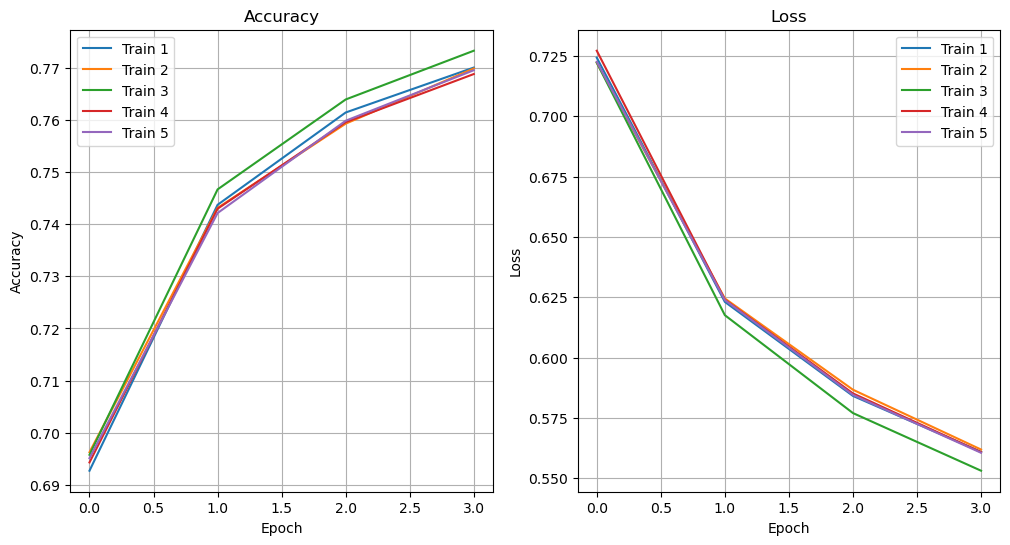

Accuracy for test set 1: 0.7618895769119263
Accuracy for test set 2: 0.7603419423103333
Accuracy for test set 3: 0.7507623434066772
Accuracy for test set 4: 0.7606806755065918
Accuracy for test set 5: 0.7623288035392761
Mean accuracy for validation with test data: 0.7592006683349609
Standard deviation: 0.004282842847968826


In [221]:
# Model evaluation with different activation functions

accuracy_cv, loss_cv, history_cv, ss_pred_cv, cv_test_ss = cross_validation(17, activation= 'leaky', 
                                                                            regularizer=0.00001,
                                                                            dropout=True)

# Accuracy and loss
cv_plot_accuracies(history_cv, "acc_loss_reg__leaky_dp_model.png")

# Accuracy with test data
training_accuracy(history_cv, 4)

# validation accuracy statistics
print_accuracy_statistics(accuracy_cv)


So far, this seems to be the best model architecture yielding the higher accuracy for the test data.

- ### Adding batch normalization


Features and labels extracted: train1 and test1
Features and labels extracted: train2 and test2
Features and labels extracted: train3 and test3
Features and labels extracted: train4 and test4
Features and labels extracted: train5 and test5
1239/1239 [==============================] - 4s 3ms/step
Accuracy for training set 1: 0.7556532025337219
Accuracy for training set 2: 0.7583575248718262
Accuracy for training set 3: 0.7492502927780151
Accuracy for training set 4: 0.7577672004699707
Accuracy for training set 5: 0.7595035433769226


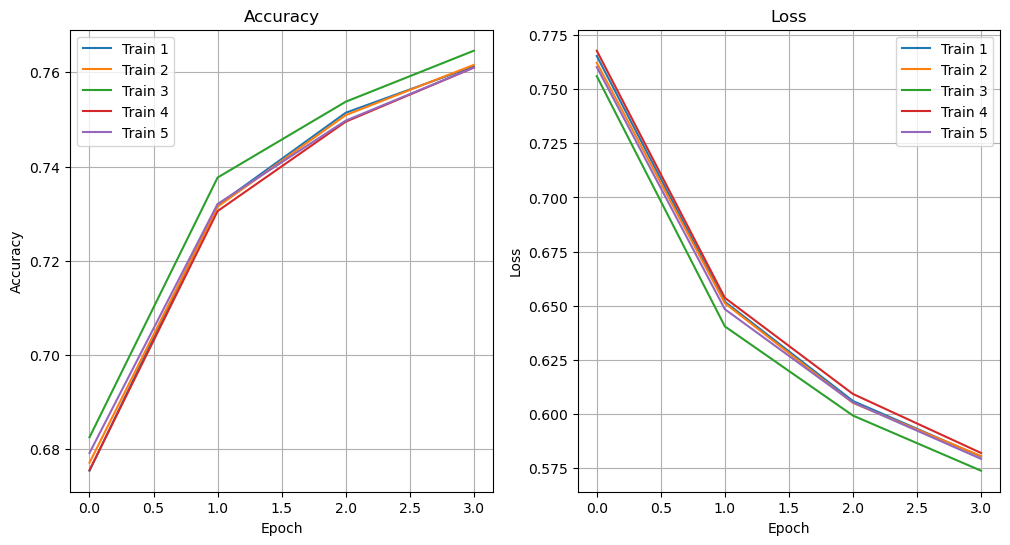

Accuracy for test set 1: 0.7556532025337219
Accuracy for test set 2: 0.7583575248718262
Accuracy for test set 3: 0.7492502927780151
Accuracy for test set 4: 0.7577672004699707
Accuracy for test set 5: 0.7595035433769226
Mean accuracy for validation with test data: 0.7561063528060913
Standard deviation: 0.0036490546360567412


In [242]:
# Model evaluation with different activation functions

accuracy_cv, loss_cv, history_cv, ss_pred_cv, cv_test_ss = cross_validation(17, activation= 'leaky', 
                                                                            regularizer=0.00001,
                                                                            dropout=True,
                                                                            batch_norm=True)

# Accuracy and loss
cv_plot_accuracies(history_cv, "acc_loss_batch_norm_model.png")

# Accuracy with test data
training_accuracy(history_cv, 4)

# validation accuracy statistics
print_accuracy_statistics(accuracy_cv)

Batch normalization decreases the accuracy over the test set. Therefore, we won't include it in the final model.

- ### Plot for hyperparamenter tuning and accuracy accross cross-validation sets

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


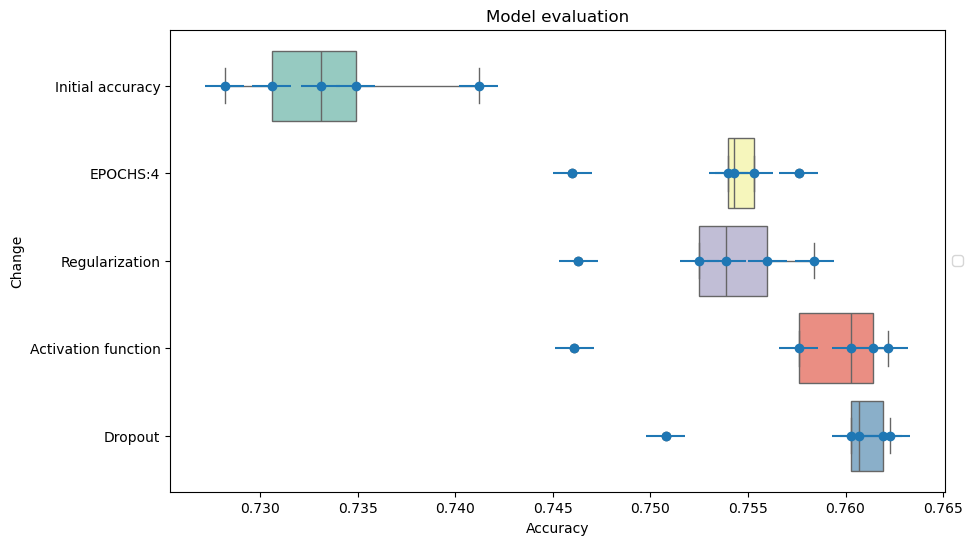

In [74]:
## Boxplot of main matrics

import pandas as pd
import seaborn as sns

# import data frame
with open('all_metrics.txt', 'r') as file:
    metrics = pd.read_csv(file, sep='\t')
    metrics_long = metrics.melt(id_vars='Cross-validation set', var_name='Change', value_name='Accuracy')
    # Change comma to dot in Accuracy column
    metrics_long['Accuracy'] = metrics_long['Accuracy'].str.replace(',', '.').astype(float)

# Boxplot
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(x='Accuracy', y='Change', data=metrics_long, hue='Change', palette='Set3')
ax.set_title('Model evaluation')
# Add error bars
ax.errorbar(metrics_long['Accuracy'], metrics_long['Change'], xerr=0.001, fmt='o')

# change legend position to outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('boxplot_metrics.png')
plt.show()

# Plot 



## Validation of model with blind-data

In [14]:
# Blind test
window_size=17
file_path = r"data\blindTest\list.txt"
pssm_files = "data\\blindTest\\pssm"
dssp_files = "data\\blindTest\\dssp"

blindt_x, blindt_y = extract_features(file_path, pssm_files, dssp_files, window_size)
print(blindt_x.shape)
print(blindt_y.shape)


(62136, 340)
(62136, 3)


In [15]:
# Cross-validation
def cv_blindset(window_size, activation, regularizer=None, dropout=False, batch_norm=False,
                file_path=None, pssm_files=None, dssp_files=None):
    
    #Take the features and labels from the cross-validation data
    cv_train, cv_train_ss, cv_test, cv_test_ss = cv_features(window_size)

    # Take the features and labels from the blind test data
    blindt_x, blindt_y = extract_features(file_path, pssm_files, dssp_files, window_size)
    # Train and evaluate the model for each fold
    accuracy_cv, loss_cv, history_cv, ss_pred_cv = [], [], [], []
    # Train and evaluate the model for each fold
    for i in range(len(cv_train)):
        accuracy, loss, history, ss_pred = cv_model(cv_train[i], 
                                                    cv_train_ss[i],
                                                    blindt_x[i],
                                                    blindt_y[i],
                                                    activation=activation,
                                                    regularizer=regularizer,
                                                    dropout=dropout,
                                                    batch_norm=batch_norm)
        accuracy_cv.append(accuracy)
        loss_cv.append(loss)
        history_cv.append(history)
        ss_pred_cv.append(ss_pred)
        
    return accuracy_cv, loss_cv, history_cv, ss_pred_cv, blindt_y


Features and labels extracted: train1 and test1
Features and labels extracted: train2 and test2
Features and labels extracted: train3 and test3
Features and labels extracted: train4 and test4
Features and labels extracted: train5 and test5
1239/1239 [==============================] - 3s 2ms/step


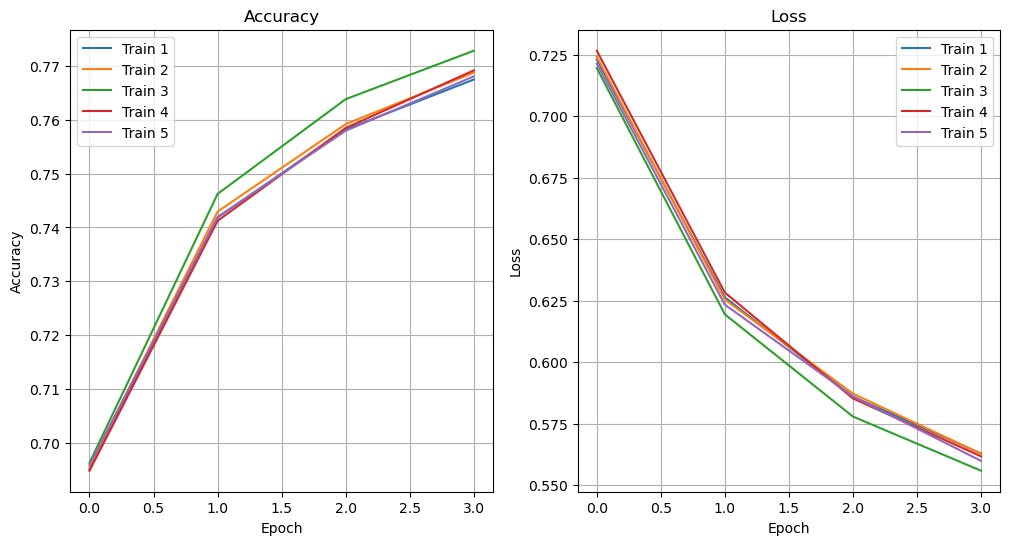

Accuracy training set 1: 0.7674935460090637
Accuracy training set 2: 0.7687810063362122
Accuracy training set 3: 0.7728484869003296
Accuracy training set 4: 0.7691921591758728
Accuracy training set 5: 0.7680835723876953
Validation accuracy for training set 1: 0.7614476084709167
Validation accuracy for training set 2: 0.7636238932609558
Validation accuracy for training set 3: 0.7473098039627075
Validation accuracy for training set 4: 0.7610931992530823
Validation accuracy for training set 5: 0.7629594206809998
Mean accuracy for validation with test data: 0.7592867851257324
Standard deviation: 0.006061008599341709


In [16]:
# Model evaluation with blind test data cross-validation

acc_cv_bs, loss_cv_bs, history_cv_bs, ss_pred_cv_bs, ss_bs = cross_validation(17, activation= 'leaky', 
                                                                            regularizer=0.00001,
                                                                            dropout=True,
                                                                            batch_norm=False)

# Accuracy and loss
#cv_plot_accuracies(history_cv_bs, "acc_loss_blindset.png")
# Accuracy with test data
training_accuracy(history_cv_bs, 4)
# validation accuracy statistics
print_accuracy_statistics(acc_cv_bs)

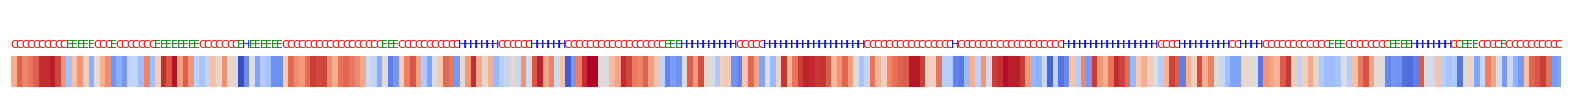

In [57]:
def convert(probs_array):
    ''' 
    Convert the probabilities to a sequence
    '''
    sequence = ''
    probabilities = []
    for prob in probs_array:
        max_prob_index = np.argmax(prob)
        probabilities.append(prob[max_prob_index])
        if max_prob_index == 0:
            sequence += 'H'  # Helix
        elif max_prob_index == 1:
            sequence += 'E'  # Sheet
        else:
            sequence += 'C'  # Coil
    return sequence, probabilities

import numpy as np
import matplotlib.pyplot as plt

def plot_sequence(sequence, probabilities):
    ''' 
    Plot the sequence with corresponding probabilities
    '''
    # Create a color map for each class
    colors = {'H': 'blue', 'E': 'green', 'C': 'red'}

    # Convert sequence to uppercase
    sequence = sequence.upper()
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(20, 1))
    
    # Plot each character in the sequence with corresponding color
    for i, char in enumerate(sequence):
        ax.text(i, 0, char, color=colors[char], ha='center', fontsize=8)

    # Plot a heatmap of probabilities below the sequence
    ax.imshow([probabilities], cmap='coolwarm', aspect='auto', extent=[-0.5, len(sequence) - 0.2, -1, -0.2])

    # Set plot limits and remove axes
    ax.set_xlim(-0.5, len(sequence) - 0.5)
    ax.set_ylim(-1, 1)
    ax.axis('off')

    # Show the plot
    plt.show()

# Assuming ss_pred_cv_bs[4] contains the probabilities array
probabilities_array = ss_pred_cv_bs[4]

# Assuming each protein has 280 characters
num_characters = 280

# Extract probabilities for the first protein
probabilities_first_protein = probabilities_array[:num_characters]

# Convert the probabilities to a sequence
sequence, probabilities = convert(probabilities_first_protein)
# plot the sequence
plot_sequence(sequence, probabilities)

In [28]:
def confusion_matrix(ss_pred_cv_bs, ss_bs):
    confusion_matrix_cv = []
    conf_matrix = np.zeros((3, 3))
    for i in range(len(ss_pred_cv_bs)):
        ss_pred = np.argmax(ss_pred_cv_bs[i], axis=1)
        ss_true = np.argmax(ss_bs[i], axis=1)
        conf_matrix = tf.math.confusion_matrix(ss_true, ss_pred, num_classes=3)
        confusion_matrix_cv.append(conf_matrix)
    
    return confusion_matrix_cv

def confusion_matrix_plot(conf_matrix, title, save_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', 
                xticklabels=['H', 'E', 'C'], 
                yticklabels=['H', 'E', 'C'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.savefig(save_name)
    plt.show()

# Calculate precision, recall and F1-score
def precision_recall_f1(conf_matrix):
    precision = np.zeros(3)
    recall = np.zeros(3)
    f1_score = np.zeros(3)
    for i in range(3):
        precision[i] = conf_matrix[i, i] / np.sum(conf_matrix[:, i])
        recall[i] = conf_matrix[i, i] / np.sum(conf_matrix[i, :])
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    return precision, recall, f1_score


In [23]:
# Cross-validation stats
confusion_matrix_cv = confusion_matrix(ss_pred_cv_bs, ss_bs)

precision_lst, recall_lst, f1_score_lst = [], [], []

for cm in confusion_matrix_cv:
    precision, recall, f1_score = precision_recall_f1(cm)
    precision_lst.append(precision)
    recall_lst.append(recall)
    f1_score_lst.append(f1_score)

# Mean precision, recall and F1-score
mean_precision = np.mean(precision_lst, axis=0)
mean_sd_precision = np.std(precision_lst, axis=0)
print(f"Mean precision: {mean_precision}")
print(f"Standard deviation: {mean_sd_precision}")
mean_recall = np.mean(recall_lst, axis=0)
mean_sd_recall = np.std(recall_lst, axis=0)
print(f"Mean recall: {mean_recall}")
print(f"Standard deviation: {mean_sd_recall}")
mean_f1_score = np.mean(f1_score_lst, axis=0)
mean_sd_f1_score = np.std(f1_score_lst, axis=0)
print(f"Mean F1-score: {mean_f1_score}")
print(f"Standard deviation: {mean_sd_f1_score}")



Mean precision: [0.82069199 0.71213308 0.73341023]
Standard deviation: [0.01536797 0.02090704 0.00952749]
Mean recall: [0.80558174 0.61831245 0.79421945]
Standard deviation: [0.01055692 0.02139578 0.02554441]
Mean F1-score: [0.81289865 0.66134247 0.76222565]
Standard deviation: [0.00605784 0.00931844 0.00688447]


In [ ]:
# Plot precision, recall and F1-score for each fold according to list

def plot_metrics(metrics, title, save_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    # For each class (H, E, C)
    classes = ['H','E','C']
    palette = sns.color_palette("Set2")  # Choose a colormap (e.g., "Set1")
    for class_label in range(len(classes)):
        class_metric_scores = [metrics[j][class_label] for j in range(len(metrics))]
        ax.plot(range(1, len(metrics) + 1), class_metric_scores, marker='o', label=f'Structure {classes[class_label]}', color=palette[class_label])
    ax.legend()
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.set_xlabel('Cross-validation set')
    plt.xticks(range(1, len(f1_scores) + 1))
    ax.grid(True)
    plt.savefig(save_name)
    plt.show()


plot_metrics(precision_lst, 'Precision', 'precision_blindset.png')
plot_metrics(recall_lst, 'Recall', 'recall_blindset.png')
plot_metrics(f1_score_lst, 'F1-score', 'f1_score_blindset.png')




### Comparison to another model
This model uses different number of units of those suggested by the Keras tuner

In [231]:
# Define the model architecture following the best hyperparameters

import keras
from keras.layers import Dense, Flatten, LeakyReLU, Dropout, BatchNormalization
from keras import regularizers

def cv_model2(train_set, train_ss, test_set, ss_test, activation='leaky', regularizer=None, dropout=False):
    
    # Define the model architecture
    model = keras.Sequential([
        Flatten(input_shape=(train_set.shape[1],)),
    ])
    
    if activation == 'leaky':
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
    elif activation == 'relu':
        model.add(Dense(256, activation='relu'))
    elif activation == 'sigmoid':
        model.add(Dense(256, activation='sigmoid'))
    else:
        raise ValueError("Invalid activation function specified.")
    
    model.add(Dense(128, activation='relu'))
    
    if dropout:
        model.add(Dropout(0.25))
    
    model.add(Dense(64, activation='relu'))
    
    if dropout:
        model.add(Dropout(0.25))
    
    model.add(Dense(3, activation='softmax'))
    
    # Add activity regularization if specified
    if regularizer:
        model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.L1(l1=regularizer)))
    
    # Add batch normalization
    model.add(BatchNormalization())
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
    # Train the model
    history = model.fit(train_set, train_ss, epochs=10, batch_size=128, validation_split=0.2, verbose=0)
        
    # Evaluate the model
    loss, accuracy = model.evaluate(test_set, ss_test)

    # Predict with the model
    ss_pred = model.predict(test_set)
    
    return accuracy, loss, history, ss_pred



# Cross-validation
def cross_validation2(window_size, activation, regularizer=None, dropout=False):
    
    #Take the features and labels from the cross-validation data
    cv_train, cv_train_ss, cv_test, cv_test_ss = cv_features(window_size)
    accuracy_cv, loss_cv, history_cv, ss_pred_cv = [], [], [], []
    # Train and evaluate the model for each fold
    for i in range(len(cv_train)):
        accuracy, loss, history, ss_pred = cv_model2(cv_train[i], 
                                                    cv_train_ss[i],
                                                    cv_test[i],
                                                    cv_test_ss[i],
                                                    activation=activation,
                                                    regularizer=regularizer,
                                                    dropout=dropout)
        accuracy_cv.append(accuracy)
        loss_cv.append(loss)
        history_cv.append(history)
        ss_pred_cv.append(ss_pred)
        
    return accuracy_cv, loss_cv, history_cv, ss_pred_cv, cv_test_ss


Features and labels extracted: train1 and test1
Features and labels extracted: train2 and test2
Features and labels extracted: train3 and test3
Features and labels extracted: train4 and test4
Features and labels extracted: train5 and test5
1239/1239 [==============================] - 3s 2ms/step


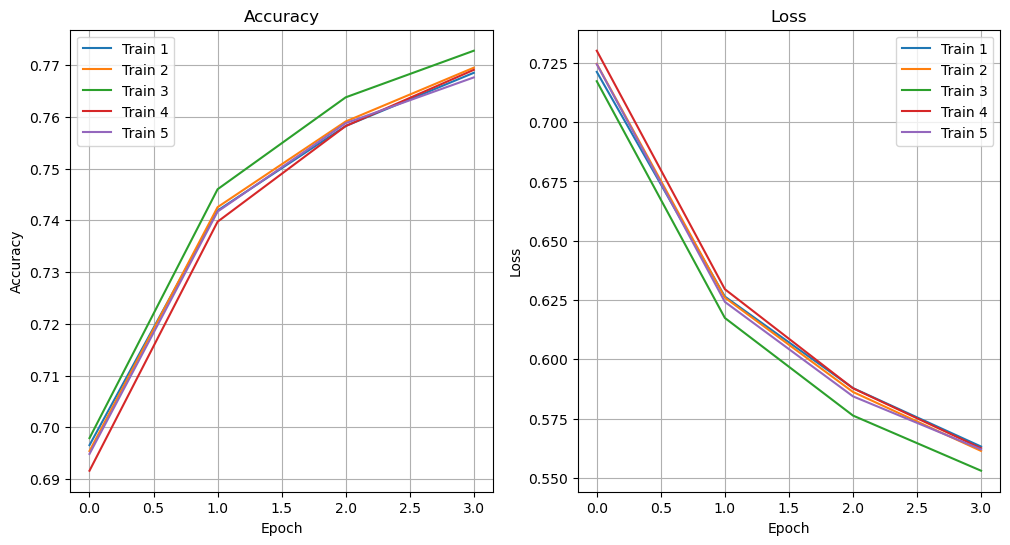

Accuracy training set 1: 0.7685099840164185
Accuracy training set 2: 0.7694971561431885
Accuracy training set 3: 0.7727774977684021
Accuracy training set 4: 0.7690823674201965
Accuracy training set 5: 0.7676182985305786
Validation accuracy for training set 1: 0.7605146169662476
Validation accuracy for training set 2: 0.7619701623916626
Validation accuracy for training set 3: 0.751997172832489
Validation accuracy for training set 4: 0.7599329352378845
Validation accuracy for training set 5: 0.7625558376312256
Mean accuracy for validation with test data: 0.7593941450119018
Standard deviation: 0.0038181963147803926


In [73]:
# Model evaluation with different number of units

accuracy_cv, loss_cv, history_cv, ss_pred_cv, cv_test_ss = cross_validation(17, activation= 'leaky', 
                                                                            regularizer= 1e-5,
                                                                            dropout=True)

# Accuracy and loss
cv_plot_accuracies(history_cv, "acc_loss_unit_change.png")

# Training accuracy
training_accuracy(history_cv, 4)

# validation accuracy statistics
print_accuracy_statistics(accuracy_cv)

Although this architecture is different it shows similar accuracy values to our model.